# Convolutional Neural Network to Identify MNIST Digits

## Setup and Exploratory Data Analysis

In [343]:
import tensorflow as tf
from tensorflow.config import list_physical_devices
from tensorflow.config.experimental import get_device_details
# import keras
from keras.utils import set_random_seed
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.datasets import mnist

from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

Let's see if we can have any GPUs we can use with this model.  

In [328]:
devices = list_physical_devices()
print("\nDevices: ", devices)

gpus = list_physical_devices('GPU')
if gpus:
  details = get_device_details(gpus[0])
  print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


Here we define some constants that we will use later.

In [329]:
RANDOM_SEED = 0
set_random_seed(RANDOM_SEED)
TRAINING_SIZE = 50_000
VALIDATION_SIZE = 10_000
NUM_EPOCHS = 60
BATCH_SIZE = 128

Load and split the data into train, test and validation sets.  

In [330]:
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

In [331]:
X_train_full.shape, y_train_full.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [332]:
assert X_train_full.shape[0] >= TRAINING_SIZE + VALIDATION_SIZE
X_train_full = X_train_full.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

In [333]:
X_valid, X_train = X_train_full[:VALIDATION_SIZE], X_train_full[VALIDATION_SIZE:TRAINING_SIZE + VALIDATION_SIZE]
y_valid, y_train = y_train_full[:VALIDATION_SIZE], y_train_full[VALIDATION_SIZE:TRAINING_SIZE + VALIDATION_SIZE]

Let's draw a block of digits and overlay the labels.  

In [384]:
def plot_images(images, labels, n_rows=8, n_cols=8):
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            if index >= len(images):
                break
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(images[index], cmap="binary", interpolation="nearest")
            plt.axis("off")
            plt.text(.1, .9, labels[index], color="blue")
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

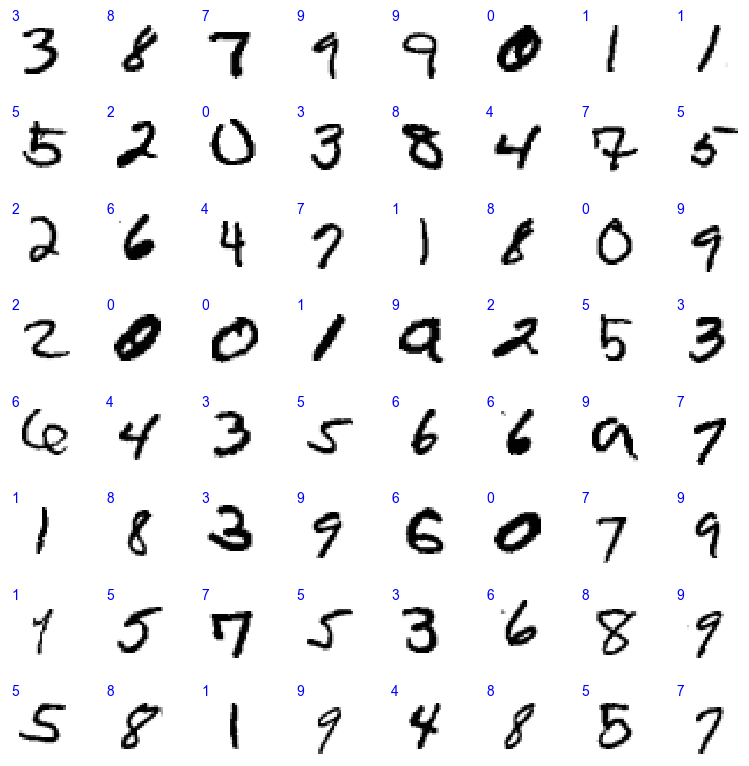

In [385]:
plot_images(X_train, y_train)

## Building the Model

In [335]:
model = Sequential([
Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1), padding="same", data_format="channels_last", name="conv_1", activation="relu"),
Dropout(rate=0.4),
MaxPool2D(pool_size=(2, 2), name="pool_1"),
Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), padding="same", data_format="channels_last", name="conv_2", activation="relu"), 
Dropout(rate=0.4),
MaxPool2D(pool_size=(2, 2), name="pool_2"),
Flatten(),
Dense(units=128, name="fc_1", activation="relu"),
Dropout(rate=0.5),
Dense(units=10, name="fc_2", activation="softmax")
])

In [336]:
model.build(input_shape=(None, 28, 28, 1))
model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 14, 14, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 454,922 (1.74 MB)

 Trainable params: 454,922 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

You can select the appropriate processor below:

In [337]:
lr_schedule = ExponentialDecay(initial_learning_rate=1e-3, decay_steps=1000, decay_rate=0.9, staircase=True)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
with tf.device("GPU: 0"):
    history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, validation_data=(X_valid, y_valid), batch_size=BATCH_SIZE)

Epoch 1/60
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.7555 - loss: 0.9271 - val_accuracy: 0.9747 - val_loss: 0.0869
Epoch 2/60
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9551 - loss: 0.2017 - val_accuracy: 0.9795 - val_loss: 0.0718
Epoch 3/60
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9650 - loss: 0.1643 - val_accuracy: 0.9811 - val_loss: 0.0667
Epoch 4/60
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9701 - loss: 0.1429 - val_accuracy: 0.9856 - val_loss: 0.0536
Epoch 5/60
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9762 - loss: 0.1178 - val_accuracy: 0.9868 - val_loss: 0.0459
Epoch 6/60
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9770 - loss: 0.1117 - val_accuracy: 0.9860 - val_loss: 0.0506
Epoch 7/60
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9789 - loss: 0.1032 - val_accuracy: 0.9888 - val_loss: 0.0406
Epoch 8/60
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9815 - loss: 0.0919 - 

## Model Evaluation

Let's see how our training and validation accuracy/loss evolves with model training.  

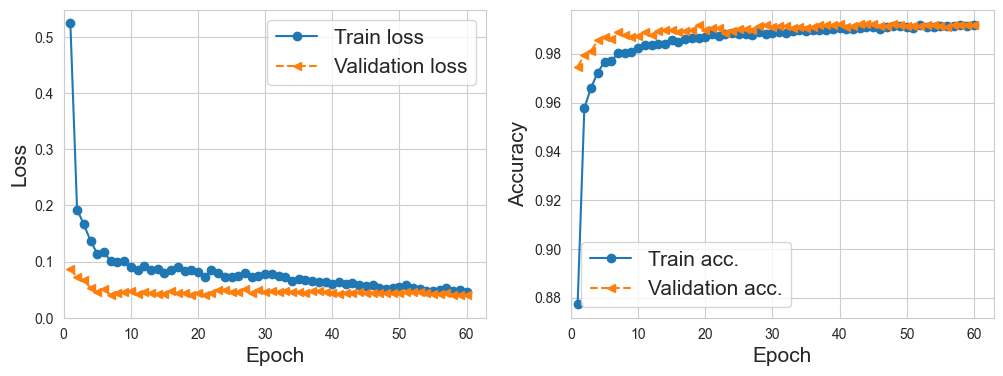

In [338]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlim(0)
ax.set_xlabel('Epoch', size=15)
ax.set_ylim(0)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlim(0)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [339]:
test_results = model.evaluate(X_test, y_test)
print(f"Test loss: {test_results[0]:.4f}, test acc: {test_results[1]:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9941 - loss: 0.0286
Test loss: 0.0238, test acc: 0.9949


Let's plot a confusion matrix to see where our errors are clustered.  We'll also plot the misidentified digits along with their predicted labels.  

In [344]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


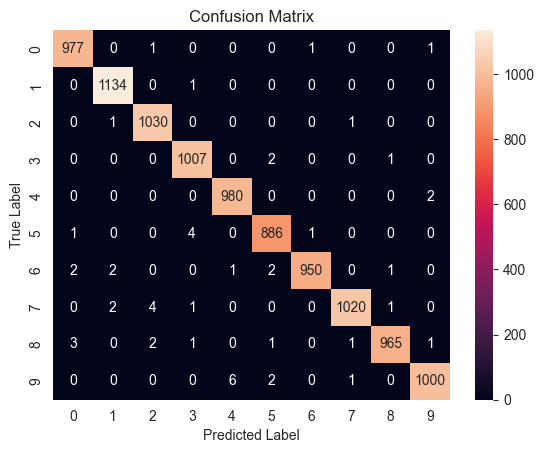

In [362]:
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

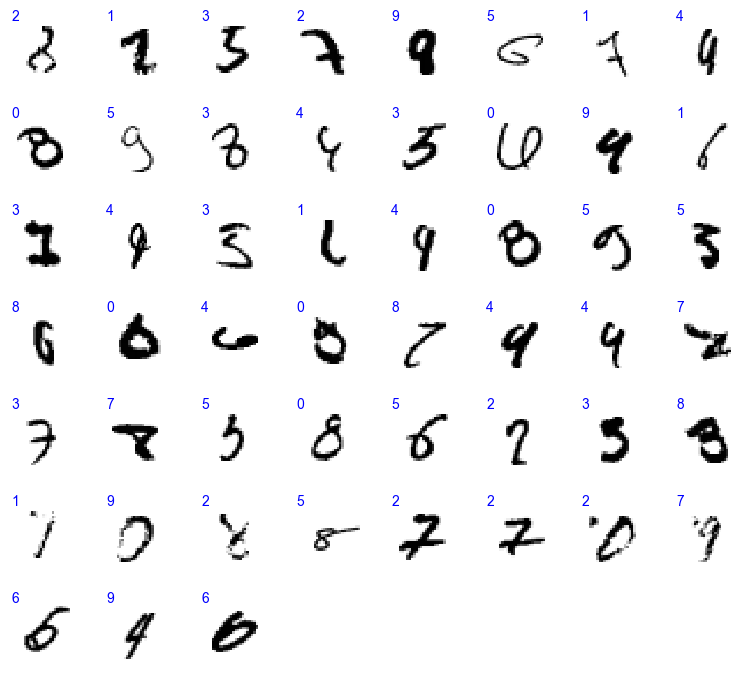

In [387]:
bad_indices = np.where(y_pred_classes != y_test)[0]
bad_images = X_test[bad_indices]
n_cols = 8
n_rows = bad_images.shape[0] // n_cols + 1
plot_images(bad_images, y_pred_classes[bad_indices], n_rows=n_rows, n_cols=n_cols)
